## 1D CNN Model - Training

In [ ]:
"""
@authors: Donggeun Kim
@affiliation: NYSPI, Columbia University
@date: Oct 2018 - Oct 2020
@overview: Architecture implementation and model training for the Experiment A 1D CNN model in Keras.
@input: LOOCV Train/Test folds of 300-length hyperaligned voxels as numpy arrays. LOOCV Train/Test labels.
@output: Trained model checkpoints (.ckpt & metadata)
"""

In [1]:
import numpy as np
import pandas as pd
import keras
from keras import backend as K
from keras.callbacks import History
import pickle
from keras import initializers
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Activation
from keras.layers.convolutional import Conv1D, MaxPooling1D, ZeroPadding1D
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import glob
import os
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, show
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl
from sklearn import preprocessing
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier

from sklearn.metrics import roc_curve,roc_auc_score

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
folder_root = '/content/drive/My Drive/BrainStateClassification/code/'#Update to your main folder, this folder must contain a data and a result subfolder
folder_data = folder_root + 'data/' #folder containing all the .mat files
folder_result = folder_root + 'data/plateau' #folder where your models and logs will be stored


In [4]:
os.chdir(folder_data)

In [5]:
Y = np.loadtxt('Y_hyp_v2.csv',delimiter=",")
X = np.loadtxt('X_hyp_v2.csv',delimiter=",")

In [6]:
from collections import Counter
Counter(Y)

Counter({0.0: 2200, 1.0: 1100, 2.0: 1100})

In [ ]:
np.shape(X)

(4400, 300)

In [ ]:
bias_regularization = 0.005
kernel_regularization = 0.005

def create_model():
    model = Sequential()
    model.add(Conv1D(128, (10), input_shape=(300,1)))
    model.add(Conv1D(128, (10)))
    model.add(Conv1D(128, (10)))
    model.add(Conv1D(64, (10)))
    model.add(Conv1D(64, (10)))
    model.add(Conv1D(64, (10)))
    model.add(Flatten())
    model.add(Dropout(0.25))
    model.add(Dense(1024, activation='relu',kernel_regularizer=keras.regularizers.l1(kernel_regularization),
                           bias_regularizer=keras.regularizers.l1(bias_regularization)))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu',kernel_regularizer=keras.regularizers.l1(kernel_regularization),
                       bias_regularizer=keras.regularizers.l1(bias_regularization)))
    model.add(Dense(256, activation='relu',kernel_regularizer=keras.regularizers.l1(kernel_regularization),
                    bias_regularizer=keras.regularizers.l1(bias_regularization)))
    model.add(Dense(128, activation='relu',kernel_regularizer=keras.regularizers.l1(kernel_regularization),
                bias_regularizer=keras.regularizers.l1(bias_regularization)))
    model.add(Dense(64, activation='relu',kernel_regularizer=keras.regularizers.l1(kernel_regularization),
              bias_regularizer=keras.regularizers.l1(bias_regularization)))
    model.add(Dense(32, activation='relu',kernel_regularizer=keras.regularizers.l1(kernel_regularization),
          bias_regularizer=keras.regularizers.l1(bias_regularization)))
    model.add(Dense(16, activation='relu',kernel_regularizer=keras.regularizers.l1(kernel_regularization),
      bias_regularizer=keras.regularizers.l1(bias_regularization)))
    model.add(Dense(3, activation='softmax')) 
    return model


In [ ]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 291, 128)          1408      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 282, 128)          163968    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 273, 128)          163968    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 264, 64)           81984     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 255, 64)           41024     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 246, 64)           41024     
_________________________________________________________________
flatten (Flatten)            (None, 15744)             0

# **Manual Cross-Validation over X,y Dataset**

In [ ]:
#Warning: Running this code again will overwrite previously trained models.

tmp = list(range(0,4800,400))
X_Hold_out = [] #Holdout = testing | Max
X_CV=[]
Y_Hold_out = []
Y_CV=[]
for i in range(len(tmp)-1):
    X_Hold_out+=[X[tmp[i]:tmp[i+1]]]
    Y_Hold_out+=[Y[tmp[i]:tmp[i+1]]]
    X_CV += [np.concatenate((X[0:tmp[i]],X[tmp[i+1]:]))]
    Y_CV += [np.concatenate((Y[0:tmp[i]],Y[tmp[i+1]:]))]
N_Leave_One_Subject = len(tmp)-1


for learn_rate in [0.0045]:
    for leave_one_idx in range(N_Leave_One_Subject): 
        print(leave_one_idx)
        X_train = X_CV[leave_one_idx] # 300 refers to N_features
        Y_train = Y_CV[leave_one_idx].reshape(-1,1)
        X_test = X_Hold_out[leave_one_idx]
        Y_test = Y_Hold_out[leave_one_idx]
        
        scaler = preprocessing.StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train).reshape(-1,300,1)
        X_test = scaler.transform(X_test).reshape(-1,300,1)

#Y_..._onehot contains one hot encoded Y_... i.e, if Y[i] = 0, Y_onehot[i] = [1,0,0] 

        X_train, Y_train = RandomOverSampler(random_state=0).fit_resample(X_train.reshape(-1,300),Y_train.flatten())
        X_train = X_train.reshape(-1,300,1)
        X_test, Y_test = RandomOverSampler(random_state=0).fit_resample(X_test.reshape(-1,300),Y_test.flatten())
        X_test = X_test.reshape(-1,300,1)

        Y_train_onehot = np.eye(3)[Y_train.astype(int)].reshape(-1,3)
        Y_test_onehot = np.eye(3)[Y_test.astype(int)].reshape(-1,3)


        print("to create")
        model = create_model()

        savedpath = './plateau'
        print("created")
        
        #If the model weights have not yet been computed (i.e model did not exist), create weights file, otherwise, load the weights. Files are located in the plateau folder
        best_model_path=os.path.join(savedpath,f"weights_holdout_regularized_{leave_one_idx}_{learn_rate}.best.hdf5")
        print(best_model_path)
        if len(glob.glob(os.path.join(savedpath, f"weights_holdout_regularized_{leave_one_idx}_{learn_rate}.best.hdf5")))==0:
            print("created a new model")   
        else:
            print("loaded weights from file")
            model.load_weights(os.path.join(savedpath,f'weights_holdout_regularized_{leave_one_idx}_{learn_rate}.best.hdf5'))
        model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adam(lr=learn_rate),
                      metrics=['accuracy'])
        batch_size = 64
        epochs = 5000
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=50, min_lr=0.00001) #Reduce learning rate when a metric has stopped improving.
        checkpoint = ModelCheckpoint(best_model_path, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
        csv_logger = keras.callbacks.CSVLogger(os.path.join(savedpath, f'training_holdout_regularized_{leave_one_idx}_{learn_rate}.log'))
        print("Before Fit")
        model.fit(X_train, Y_train_onehot,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=1,
                  validation_data=(X_test, Y_test_onehot),
                  callbacks=[csv_logger,checkpoint,reduce_lr])
        print(model.summary())
        model.load_weights(os.path.join(savedpath,f'weights_holdout_regularized_{leave_one_idx}_{learn_rate}.best.hdf5'))
        score, acc = model.evaluate(X_test, Y_test_onehot, batch_size=batch_size,verbose=0)
        with open(os.path.join(savedpath,f"test_holdout_regularized_{leave_one_idx}_{learn_rate}.log"), 'a') as f:
            print("...Test size:" + "{:.3f}".format(X_test.shape[0]), file=f)
            print("...Test score:"+"{:.3f}".format(score),file=f)
            print("...Testing accuracy:" + "{:.3f}".format(acc), file=f)
        print(f'Test Accuracy for learning rate {learn_rate} CV index {leave_one_idx} is :', "{:.3f}".format(acc))


0
to create
created
./plateau/weights_holdout_regularized_0_0.0045.best.hdf5
created a new model
Before Fit


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
94/94 [==============================] - 1s 12ms/step - loss: 0.7867 - accuracy: 0.6488 - val_loss: 0.7311 - val_accuracy: 0.6600
Epoch 2524/5000
94/94 [==============================] - 1s 13ms/step - loss: 0.7849 - accuracy: 0.6405 - val_loss: 0.7359 - val_accuracy: 0.6417
Epoch 2525/5000
94/94 [==============================] - 1s 13ms/step - loss: 0.7985 - accuracy: 0.6432 - val_loss: 0.7468 - val_accuracy: 0.6433
Epoch 2526/5000
94/94 [==============================] - 1s 13ms/step - loss: 0.8027 - accuracy: 0.6453 - val_loss: 0.7504 - val_accuracy: 0.6517
Epoch 2527/5000
94/94 [==============================] - 1s 13ms/step - loss: 0.8048 - accuracy: 0.6365 - val_loss: 0.7380 - val_accuracy: 0.6567
Epoch 2528/5000
94/94 [==============================] - 1s 14ms/step - loss: 0.7918 - accuracy: 0.6425 - val_loss: 0.7460 - val_accuracy: 0.6500
Epoch 2529/5000
94/94 [==============================] - 1s 14ms/step - loss: 0.7928 - accuracy: 0.6435 

Cross-Validation Number  7 :


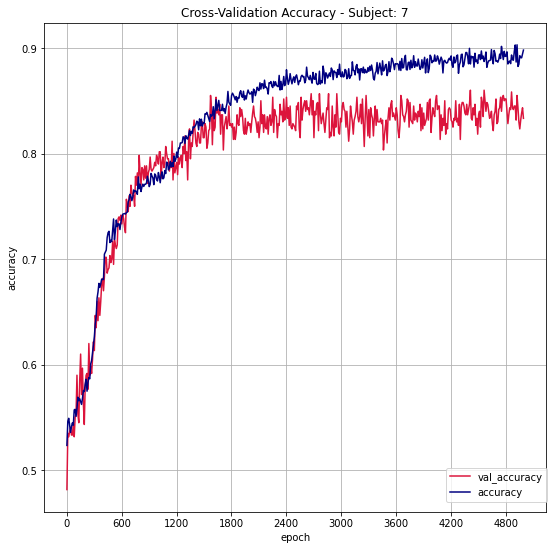

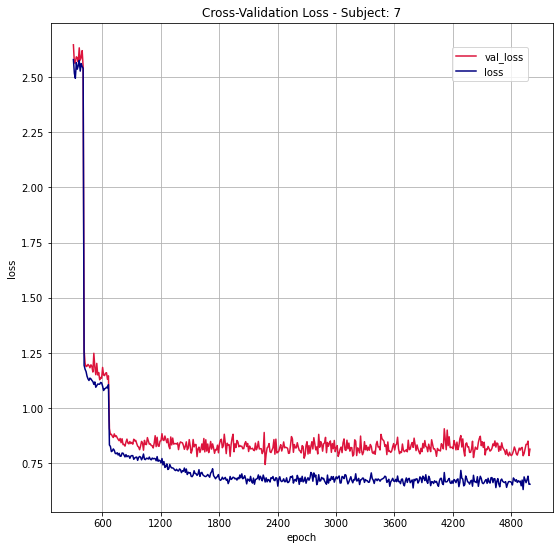

In [10]:
import pandas as pd
tmp = list(range(0,4800,400))
N_Leave_One_Subject = len(tmp)-1

for learn_rate in [0.0045]:
    for leave_one_idx in [7]:
        model_num = leave_one_idx
        print('Cross-Validation Number ',leave_one_idx,':')
        train_result = pd.read_csv(os.path.join('./plateau',f'training_holdout_regularized_{model_num}_{learn_rate}.log'))
        train_result = train_result[train_result.epoch < 5001][train_result.epoch > 1].iloc[::10]

        ax = figure(0).gca()
        ax.plot('epoch','val_accuracy',data=train_result,color='crimson')
        ax.plot('epoch','accuracy',data=train_result,color='navy')
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.legend(bbox_to_anchor=(0.8, 0.09), loc='upper left', borderaxespad=0.)
        plt.title('Cross-Validation Accuracy - Subject: '+str(leave_one_idx))
        ax.set_xlabel('epoch')
        ax.set_ylabel('accuracy')
        ax.set_yticks(np.arange(0.5,1,0.1))
        fig = ax.get_figure()
        fig.set_figheight(9)
        fig.set_figwidth(9) 
        plt.grid()
        #fig.savefig("fixed-acc_cv"+str(leave_one_idx)+"_lr_"+str(learn_rate)+".png")

        train_result = train_result[train_result.epoch > 300]

        ax2 = figure(1).gca()
        ax2.plot('epoch','val_loss',data=train_result,color='crimson')
        ax2.plot('epoch','loss',data=train_result,color='navy')
        ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax2.legend(bbox_to_anchor=(0.8, 0.95), loc='upper left', borderaxespad=0.)
        ax2.set_xlabel('epoch')
        ax2.set_ylabel('loss')
        plt.title('Cross-Validation Loss - Subject: '+str(leave_one_idx))

        fig2 = ax2.get_figure()
        fig2.set_figheight(9)
        fig2.set_figwidth(9)  
        plt.grid()    
        fig2.savefig("fixed-loss_cv"+str(leave_one_idx)+"_lr_"+str(learn_rate)+"_zoom.png")

        show()